In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [ ]:
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))


Train samples: 60000
Test samples: 10000


In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 400),
            nn.ReLU(),
        )
        self.fc_mu     = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu     = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x_hat = self.decoder(z)
        return x_hat.view(-1, 1, 28, 28)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar


In [ ]:
latent_dim = 2  # Easy to visualize
model = VAE(latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
#  ELBO Loss = Recon Loss + KL Divergence

def loss_function(x_hat, x, mu, logvar):

    x = x.view(x.size(0), -1)
    x_hat = x_hat.view(x_hat.size(0), -1)

    # Reconstruction loss
    recon_loss = F.binary_cross_entropy(x_hat, x, reduction="sum")

    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kl_loss, recon_loss, kl_loss


In [ ]:

def train_epoch(epoch):
    model.train()
    total_loss = total_recon = total_kl = 0

    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()

        x_hat, mu, logvar = model(x)
        loss, recon, kl = loss_function(x_hat, x, mu, logvar)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon += recon.item()
        total_kl += kl.item()

    n = len(train_dataset)
    print(f"Epoch {epoch:02d} | Loss {total_loss/n:.4f} | Recon {total_recon/n:.4f} | KL {total_kl/n:.4f}")

def test_epoch():
    model.eval()
    total_loss = total_recon = total_kl = 0

    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            x_hat, mu, logvar = model(x)
            loss, recon, kl = loss_function(x_hat, x, mu, logvar)

            total_loss += loss.item()
            total_recon += recon.item()
            total_kl += kl.item()

    n = len(test_dataset)
    print(f"[Test] Loss {total_loss/n:.4f} | Recon {total_recon/n:.4f} | KL {total_kl/n:.4f}")


In [ ]:
num_epochs = 7 

for epoch in range(1, num_epochs + 1):
    train_epoch(epoch)
    test_epoch()


Epoch 01 | Loss 148.2810 | Recon 141.6267 | KL 6.6542
[Test] Loss 150.6827 | Recon 144.3491 | KL 6.3337
Epoch 02 | Loss 147.9171 | Recon 141.4427 | KL 6.4744
[Test] Loss 150.1711 | Recon 143.7450 | KL 6.4261
Epoch 03 | Loss 147.7638 | Recon 141.3475 | KL 6.4163
[Test] Loss 150.1879 | Recon 143.8838 | KL 6.3042
Epoch 04 | Loss 147.6083 | Recon 141.2250 | KL 6.3833
[Test] Loss 149.9694 | Recon 143.6064 | KL 6.3630
Epoch 05 | Loss 147.4320 | Recon 141.0538 | KL 6.3782
[Test] Loss 149.7537 | Recon 143.5132 | KL 6.2405
Epoch 06 | Loss 147.3024 | Recon 140.9279 | KL 6.3745
[Test] Loss 149.4310 | Recon 143.0938 | KL 6.3372
Epoch 07 | Loss 147.1982 | Recon 140.8333 | KL 6.3650
[Test] Loss 149.6339 | Recon 143.4086 | KL 6.2252


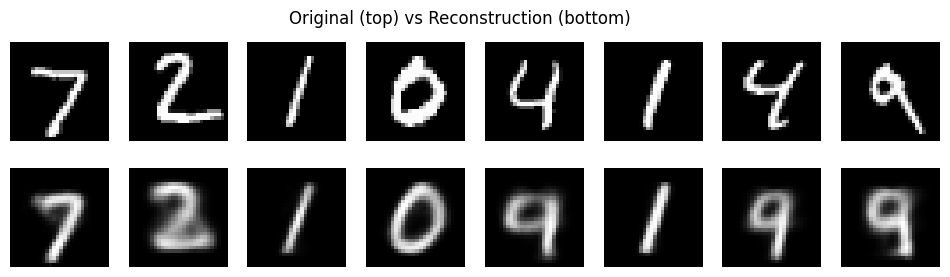

In [ ]:
def show_reconstructions():
    model.eval()
    x, _ = next(iter(test_loader))
    x = x.to(device)

    with torch.no_grad():
        x_hat, _, _ = model(x)

    x = x.cpu().numpy()
    x_hat = x_hat.cpu().numpy()

    n = 8
    plt.figure(figsize=(12, 3))

    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(x[i][0], cmap="gray")
        plt.axis("off")

        plt.subplot(2, n, n+i+1)
        plt.imshow(x_hat[i][0], cmap="gray")
        plt.axis("off")

    plt.suptitle("Original (top) vs Reconstruction (bottom)")
    plt.show()

show_reconstructions()


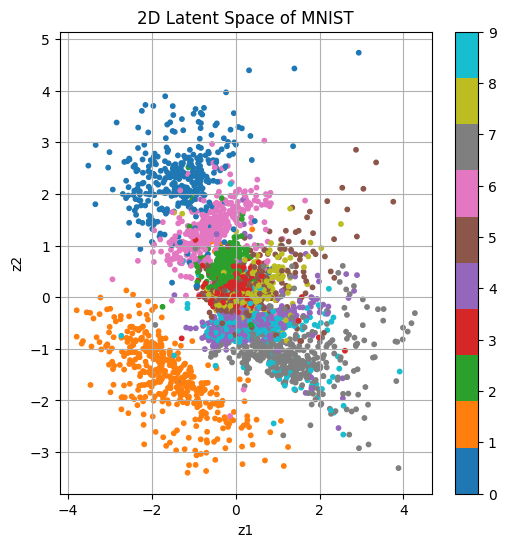

In [ ]:
def plot_latent_space(num_batches=30):
    model.eval()
    zs, labels = [], []

    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            if i >= num_batches:
                break
            x = x.to(device)
            mu, _ = model.encode(x)
            zs.append(mu.cpu().numpy())
            labels.append(y.numpy())

    zs = np.concatenate(zs, axis=0)
    labels = np.concatenate(labels, axis=0)

    plt.figure(figsize=(6, 6))
    scatter = plt.scatter(zs[:, 0], zs[:, 1], c=labels, cmap="tab10", s=10)
    plt.colorbar(scatter)
    plt.xlabel("z1")
    plt.ylabel("z2")
    plt.title("2D Latent Space of MNIST")
    plt.grid(True)
    plt.show()

plot_latent_space()
